In [1]:
import warnings; warnings.filterwarnings("ignore") # remove scanpy warnings for the tutorial.
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# import plotly.tools as tls
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import scanpy as sc
import rpy2.robjects as ro
import pandas as pd
import anndata as ad
from scipy import sparse
import torch
pd.set_option('display.max_columns', None)

In [2]:
import decipher as dc
dc.pl.activate_journal_quality()

In [7]:
adata = sc.read_csv("data/expression_mat.csv")
meta = pd.read_csv("data/cell_meta.csv", index_col=0)
var = pd.read_csv("data/gene_meta.csv", index_col=0)
color_palette = None

In [8]:
meta['cell_type'] = meta['cell_type'].str.lower()
# meta_filter = meta[~meta['cell_type'].isin(['tuft', 'proliferating', 'neuroendocrine', 'acinar tf high', 'acinar cd74+', 'mep', 'ery', 'lympho'])] # 'acinar tf high'
meta_filter = meta[~meta['cell_type'].isin(['proliferating', 'acinar tf high', 'acinar cd74+'])] # 'acinar tf high'
# meta_filter = meta[meta['cell_type'].isin(['adm', 'tuft', 'neuroendocrine'])] # 'acinar tf high'
# Subset the expression matrix to include only the filtered cells

adata_filter = adata.T[meta_filter.index]
adata_filter.obs = meta_filter
adata_filter.var = var
adata_filter.obs.index = adata_filter.obs.index.astype(str)
adata_filter.var.index = adata_filter.var['gene']
hvg = 8000
# adata_filter = adata_filter[adata_filter.obs["genotype"] != "p53 F/F"]
sc.pp.highly_variable_genes(adata_filter, flavor='seurat_v3', n_top_genes=hvg)
# Sort genes by the normalized dispersion
# adata_filter.var = adata_filter.var.sort_values('dispersions_norm', ascending=False)
# adata_filter.var = adata_filter.var.sort_values('variance', ascending=False)
# adata_hvg = adata_filter[:, adata_filter.var['highly_variable']]
# Subset the expression matrix to include only the filtered cells
# adata_filter.var = var
# adata_filter.var['variance'] = np.var(adata_filter.X, axis=0)
# adata_filter.obs['orig.ident'].unique()
adata_hvg = adata_filter[:, adata_filter.var['highly_variable']]

In [9]:
gene_signature = pd.read_csv("data/gene_signatures.csv", dtype=str, keep_default_na=False, na_values=[])
G1cells = gene_signature["G1/S"].values
G1cells = G1cells[G1cells != '']
for i in range(len(G1cells)):
    G1cells[i] = G1cells[i].capitalize()

G2cells = gene_signature["G2/M"].values
G2cells = G2cells[G2cells != '']
for i in range(len(G2cells)):
    G2cells[i] = G2cells[i].capitalize()
df = adata_hvg.to_df()
G1cells = [col for col in G1cells if col in df.columns]
G2cells = [col for col in G2cells if col in df.columns]
adata_hvg.obs["G1"] = df[G1cells].mean(axis=1).values
adata_hvg.obs["G2"] = df[G2cells].mean(axis=1).values

In [10]:
adata_hvg.write_h5ad("data/rm_acinar_tf_cd_8k.h5ad")

... storing 'orig.ident' as categorical
... storing 'experiment' as categorical
... storing 'genotype' as categorical
... storing 'timepoint' as categorical
... storing 'mouse_id' as categorical
... storing 'replicate' as categorical
... storing 'doublet_finder' as categorical
... storing 'compartment' as categorical
... storing 'cell_type' as categorical


In [5]:
# adata_F = adata_filter[adata_filter.obs["genotype"] == "p53 F/F"]
# adata_WT = adata_filter[adata_filter.obs["genotype"] != "p53 F/F"]

Epoch 64 (batch 17/17) | | train elbo: 1839.54 (last epoch: 1852.43) | val ll: 1938.41:   6%|▋         | 64/1000 [00:13<03:13,  4.83it/s]2024-08-23 07:00:12,399 | INFO : Early stopping has been triggered.
2024-08-23 07:00:12,408 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2024-08-23 07:00:12,408 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.
2024-08-23 07:00:12,409 | INFO : Saving decipher model with run_id 2024-08-23-07-00-12-extremal-auburn-segment.


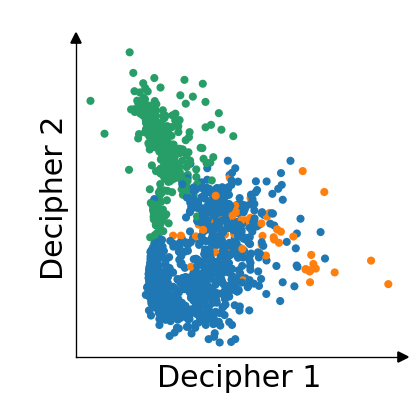

... storing 'orig.ident' as categorical
... storing 'experiment' as categorical
... storing 'genotype' as categorical
... storing 'timepoint' as categorical
... storing 'mouse_id' as categorical
... storing 'replicate' as categorical
... storing 'doublet_finder' as categorical
... storing 'compartment' as categorical
... storing 'cell_type' as categorical


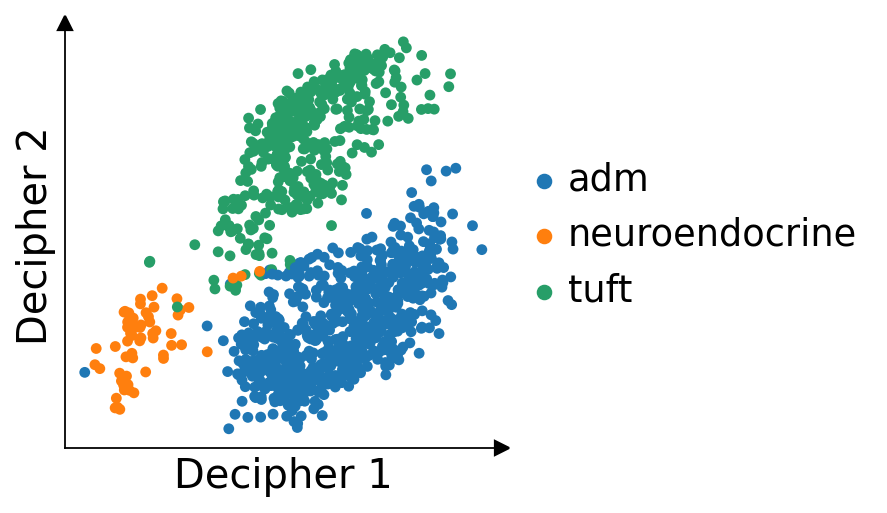

In [7]:
# Calculate highly variable genes
# Select the top n genes
# top_genes = adata_filter.var.index[:hvg]

# Subset the AnnData object to include only the top genes
# adata_hvg = adata_filter[:, top_genes]
dim_v = 2
decipher_config = dc.tl.DecipherConfig(dim_v=dim_v) # optional Decipher config
'''
dim_z: int = 10
dim_v: int = 2
layers_v_to_z: Sequence = (64,)
layers_z_to_x: Sequence = tuple()

beta: float = 1e-1 
seed: int = 0

learning_rate: float = 5e-3
val_frac: float = 0.1
batch_size: int = 64
n_epochs: int = 1000
early_stopping_patience: Optional[int] = 10

dim_genes: int = None
n_cells: int = None
prior: str = "normal"

_initialized_from_adata: bool = False
'''
d1, val1 = dc.tl.decipher_train(
    adata_hvg, decipher_config, plot_kwargs={"color": "cell_type", "palette": color_palette}, plot_every_k_epochs=5,
)

In [ ]:
adata_filter.write_h5ad("data/adm_panin1_panin2_earlypdac_gastric_tuft_neuroendocrine.h5ad")

In [7]:
def create_color_palette(colors, colormap='tab20'):
    unique_types = np.unique(colors)
    cmap = plt.get_cmap(colormap, len(unique_types))  # Get a matplotlib colormap
    return {ctype: mcolors.to_hex(cmap(i)) for i, ctype in enumerate(unique_types)}

def decipher_plot3d_plotly(
    adata,
    color=None,
    palette=None,
    subsample_frac=1.0,
    title="",
    basis="decipher_v",
    x_label="Decipher 1",
    y_label="Decipher 2",
    z_label="Decipher 3",
    plot_gene=True,
    figsize=(6, 6),  # Used for aspect ratio in Plotly
    vmax=lambda xs: np.quantile(xs[~np.isnan(xs)], 0.99),
    **kwargs
):
    """Plot the Decipher v space in 3D using Plotly.

    Parameters are adapted for use with Plotly for interactive 3D visualization.
    """
    # Subsample the data
    adata_subsampled = sc.pp.subsample(adata, subsample_frac, copy=True)
    
    # Get the coordinates for plotting
    x = adata_subsampled.obsm[basis][:, 0]
    y = adata_subsampled.obsm[basis][:, 1]
    z = adata_subsampled.obsm[basis][:, 2]
    
    # Create the Plotly figure
    fig = go.Figure()

    if plot_gene:
        colors = adata_subsampled.to_df()[color]
        # colors_scaled = (colors - colors.min()) / (colors.max() - colors.min())
        # Create the Plotly figure
        fig = go.Figure(data=[go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=5,
                color=colors,  # Apply normalized colors
                colorscale='Viridis',  # Use a colorscale suitable for continuous data
                colorbar=dict(title=color),  # Add a colorbar with a title
                opacity=0.8
            )
        )])
    else:
        colors = adata_subsampled.obs[color]
        palette = create_color_palette(colors)
        for ctype in np.unique(colors):
            idx = colors == ctype
            fig.add_trace(go.Scatter3d(
                x=x[idx],
                y=y[idx],
                z=z[idx],
                mode='markers',
                marker=dict(
                    size=5,
                    color=palette[ctype],  # Use specific color for each cell type
                    opacity=0.8
                ),
                name=ctype  # Legend entry
            ))


    # Update the layout to add labels, title, and modify the aspect ratio
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title=x_label,
            yaxis_title=y_label,
            zaxis_title=z_label,
            aspectmode='cube',  # This keeps the aspect ratio square
            xaxis=dict(backgroundcolor="rgb(200, 200, 230)"),
            yaxis=dict(backgroundcolor="rgb(230, 200, 230)"),
            zaxis=dict(backgroundcolor="rgb(230, 230, 200)")
        ),
        width=600,  # Control width and height if needed
        height=600
    )

    return fig

In [4]:
run_id = 'rm_tuft_neuroendocrine_acinar_tf_cd_8k'
adata_hvg = sc.read(f'data/{run_id}.h5ad')
adata_hvg.uns["decipher"]["run_id"] = run_id

2024-08-19 18:13:30,337 | INFO : Added `.obsm['decipher_v']`: the Decipher v space.
2024-08-19 18:13:30,338 | INFO : Added `.obsm['decipher_z']`: the Decipher z space.


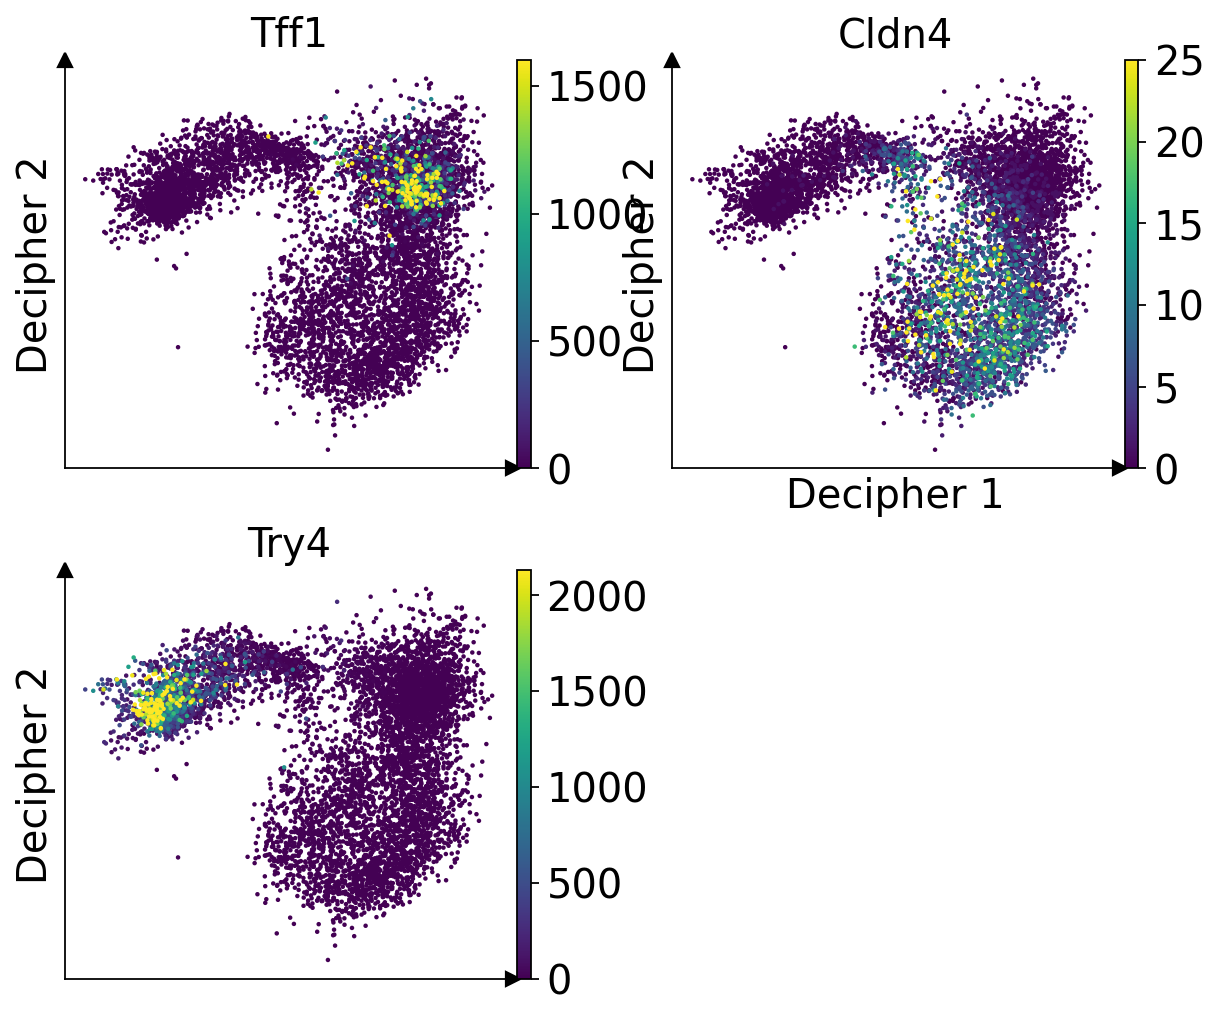

In [5]:
save_folder = '/home/qp2134/decipher/_decipher_models'
model_run_id = 'rm_tuft_neuroendocrine_acinar_tf_cd_8k'
dim_v = 2
config = dc.tl.DecipherConfig(dim_v=dim_v)
config.initialize_from_adata(adata_hvg)

model = dc.tl._decipher.decipher.Decipher(config)
model_path = os.path.join(save_folder, model_run_id, "decipher_model.pt")
model.load_state_dict(torch.load(model_path))
dc.tl.decipher._decipher_to_adata(model, adata_hvg)
dc.pl.decipher(adata_hvg, basis="decipher_v", color=['Tff1', 'Cldn4', 'Try4']) # cell_type genotype
plt.show()
# color = 'cell_type'
# fig = decipher_plot3d_plotly(adata_hvg, basis="decipher_v", color=color, plot_gene=False)
# fig.write_html(f'figures/decipher_3d_{color}.html')

2024-08-19 18:13:33,762 | INFO : Clustering cells using scanpy Leiden algorithm.
2024-08-19 18:13:33,763 | INFO : Step 1: Computing neighbors with `sc.pp.neighbors`, with the representation decipher_z.
2024-08-19 18:13:37,875 | INFO : Step 2: Computing clusters with `sc.tl.leiden`, and resolution 1.2.
2024-08-19 18:13:38,551 | INFO : Added `.obs['decipher_clusters']`: the cluster labels.


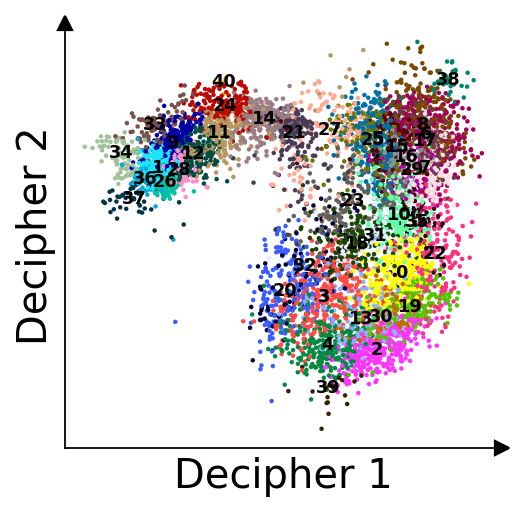

In [6]:
dc.tl.cell_clusters(adata_hvg, n_neighbors=4, leiden_resolution=1.2)
clusters = dc.pl.decipher(adata_hvg, ["decipher_clusters"], legend_loc="on data", legend_fontsize=8)

In [6]:
dc.tl.trajectories(
    adata_hvg,
    dc.tl.TConfig(name='pdac2',
        start_cluster_or_marker='37',
        end_cluster_or_marker='39',
        # cluster_ids_list=['37','36','1','26','28',
        #                   '12','11','14','21','23',
        #                   '31','0','30','2','39'], # '36','1','26','28','12','11','14','21'
        subset_col=None,
        subset_val=None,
        # cluster_ids_list=['1','0','3','4'],
        subset_percent_per_cluster=0.3,
        min_cell_per_cluster=10,),
    dc.tl.TConfig(name='gastric',
        start_cluster_or_marker='37',
        end_cluster_or_marker='38',
        subset_col=None,
        subset_val=None,
        # cluster_ids_list=['1','0','3','4'],
        subset_percent_per_cluster=0.3,
        min_cell_per_cluster=10,),
)

2024-08-16 20:35:38,148 | INFO : Trajectory pdac2 : ['37', '36', '1', '26', '28', '12', '11', '14', '21', '23', '31', '0', '30', '2', '39'])
2024-08-16 20:35:38,153 | INFO : Added trajectory pdac2 to `adata.uns['decipher']['trajectories']`.
2024-08-16 20:35:38,160 | INFO : Trajectory gastric : ['37', '36', '1', '26', '28', '12', '11', '14', '21', '27', '25', '5', '15', '16', '17', '6', '8', '38'])
2024-08-16 20:35:38,164 | INFO : Added trajectory gastric to `adata.uns['decipher']['trajectories']`.


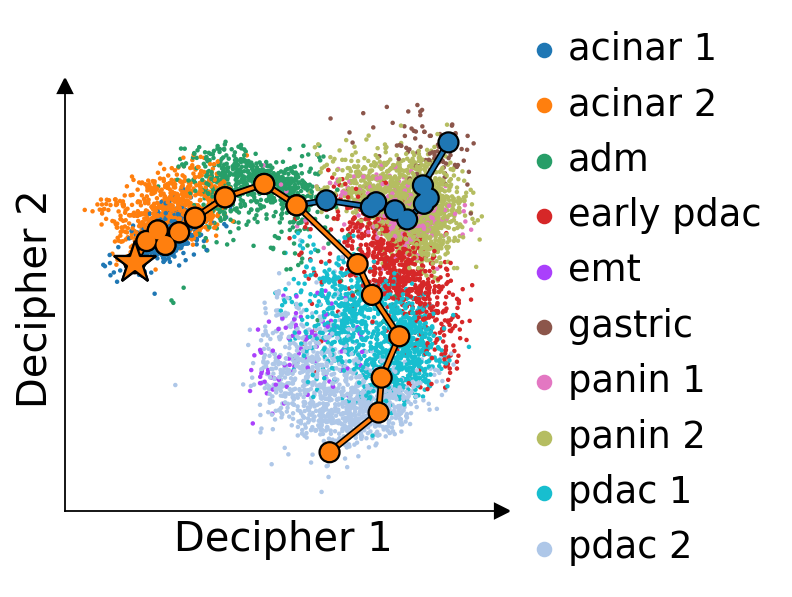

In [7]:
traj_fig = dc.pl.trajectories(adata_hvg, "cell_type")

In [ ]:
# fig = decipher_plot3d(adata_hvg, basis="decipher_v", color="cell_type")
# colors = ['Tff1', 'Cldn4', 'Try4'] # 'genotype'
# for color in colors:
#     fig = decipher_plot3d_plotly(adata_hvg, basis="decipher_v", color=color, plot_gene=True)
#     fig.write_html(f'figures/decipher_3d_{color}.html')
# plotly_fig.write_html('figures/decipher3d.html')

2024-08-16 20:36:05,636 | INFO : Added `.obs['decipher_time']`: the decipher time of each cell.


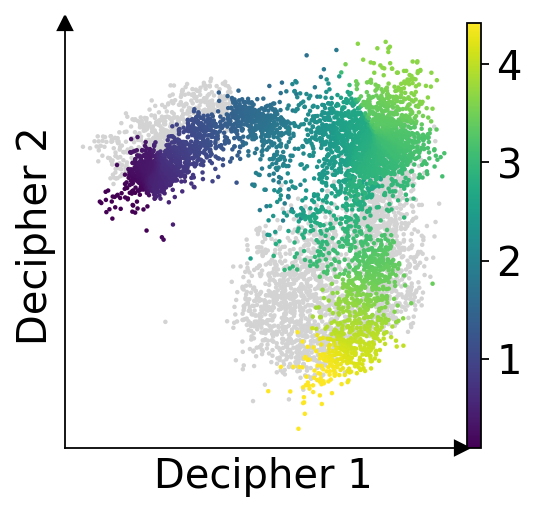

In [8]:
# dc.tl.decipher_time(adata_hvg)
# fig = dc.pl.decipher_time(adata_hvg)

In [9]:
dc.tl.decipher_gene_imputation(adata_hvg)

2024-08-16 20:36:12,344 | INFO : Added `.layers['imputed']`: the Decipher imputed data.


In [10]:
dc.tl.gene_patterns(adata_hvg)

In [18]:
adata_hvg.uns["decipher"]["trajectories"].keys()

NameError: name 'adata' is not defined

In [17]:
adata_hvg.uns["decipher"]["gene_patterns"]['pdac2'].keys()

dict_keys(['mean', 'q25', 'q75', 'mean2', 'times'])

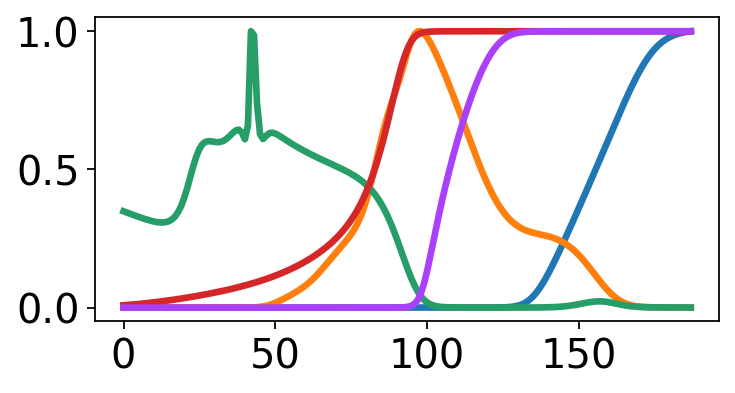

Loss: 70062.9 - Relative Error: 5.84%:  29%|██▉       | 2879/10000 [02:36<06:28, 18.35it/s] 


In [12]:
training_losses = dc.tl.basis_decomposition(adata_hvg, seed=0)

In [16]:
import logging
from sklearn.neighbors import KNeighborsClassifier

def _add_cell_type_band(
    adata, trajectory_name, cell_type_key, ax, palette=None, n_neighbors=50, offset=1
):
    trajectory = adata.uns["decipher"]["trajectories"][trajectory_name]
    if (
        "cell_types" not in trajectory
        or trajectory["cell_types"]["key"] != cell_type_key
        or (trajectory["cell_types"]["n_neighbors"] != n_neighbors)
    ):
        knc = KNeighborsClassifier(n_neighbors=n_neighbors)
        knc.fit(adata.obsm[trajectory["rep_key"]], adata.obs[cell_type_key])
        cell_types = knc.predict(trajectory["points"])
        trajectory["cell_types"] = {
            "key": cell_type_key,
            "n_neighbors": n_neighbors,
            "values": cell_types,
        }

    times = trajectory["times"]
    cell_types = trajectory["cell_types"]["values"]

    if palette is None:
        logging.info("No palette provided for the cell types, using default.")
        ct = np.unique(cell_types)
        palette = dict(zip(ct, sns.color_palette(n_colors=len(ct))))

    # Use the ax provided instead of the default plt
    ax.scatter(
        times,
        np.zeros(len(times)) - 0.05 * offset + 0.025,
        c=[palette[c] for c in cell_types],
        marker="s",
        s=20,
        transform=ax.get_xaxis_transform(),
        clip_on=False,
        edgecolors=None,
    )
    ax.xaxis.labelpad = 5 + 5 * offset

def gene_patterns(
    adata,
    gene_names,
    crop_to_min_length=False,
    smoothing_window=5,
    cell_type_key=None,
    time_axis = "times",
    palette=None,
    pattern_names=None,
    figsize=(30, 20),
    include_uncertainty=True,
    max_length=None,
    cell_type_band_pattern_names=None,
    nrows=5,
    ncols=4,
):
    """Plot the gene patterns over the Decipher time in a grid of subplots.

    Parameters
    ----------
    adata : sc.AnnData
        The annotated data matrix.
    gene_names : list of str
        The names of the genes to plot.
    crop_to_min_length : bool, default False
        Crop the plot to the minimum length of the gene patterns.
    smoothing_window : int, default 5
        The size of the window for the moving average smoothing.
    cell_type_key : str, optional
        The key of the cell type annotations in `adata.obs`. If provided, the cell types will be
        plotted as colored bands on the x-axis. See `cell_type_band_pattern_names` for more details.
    palette : dict, optional
        A dictionary mapping pattern names and cell type names to colors.
    pattern_names : str or list of str, optional
        The names of the gene patterns to plot. If None, plot all gene patterns.
    figsize : tuple of float, default (15, 10)
        The size of the figure.
    include_uncertainty : bool, default True
        Whether to include the uncertainty of the gene patterns in the plot, as a shaded area.
    max_length : int, optional
        The maximum length of the gene patterns to plot. If None, plot the full length, up to the
        minimum length of the gene patterns if `crop_to_min_length` is True.
    cell_type_band_pattern_names : str or list of str, optional
        The names of the gene patterns to use for the cell type bands. If None, use the same gene
        patterns as `pattern_names`. It is useful to use a subset of the gene patterns to avoid
        multiple bands.
    nrows : int, default 2
        Number of rows in the subplot grid.
    ncols : int, default 2
        Number of columns in the subplot grid.
    """

    # Ensure gene_names is a list
    if isinstance(gene_names, str):
        gene_names = [gene_names]

    # Create figure and axes for subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()  # Flatten in case nrows * ncols > 1

    def moving_average(x, w):
        return np.convolve(x, np.ones(w), "same") / np.convolve(np.ones_like(x), np.ones(w), "same")

    if pattern_names is None:
        pattern_names = list(adata.uns["decipher"]["gene_patterns"].keys())
    elif isinstance(pattern_names, str):
        pattern_names = [pattern_names]

    default_color_palette = sns.color_palette(n_colors=len(pattern_names))

    for i, gene_name in enumerate(gene_names):
        if i >= len(axes):
            break  # If there are more genes than subplots, exit

        gene_id = [adata.var_names.tolist().index(gene_name)]
        ax = axes[i]  # Select the appropriate subplot

        start_times = []
        end_times = []
            
        for j, p_name in enumerate(pattern_names):
            gene_pattern = adata.uns["decipher"]["gene_patterns"][p_name]

            gene_pattern_mean = gene_pattern["mean"][:, gene_id].mean(axis=1)
            gene_pattern_mean = moving_average(gene_pattern_mean, smoothing_window)
            gene_pattern_q25 = gene_pattern["q25"][:, gene_id].mean(axis=1)
            gene_pattern_q25 = moving_average(gene_pattern_q25, smoothing_window)
            gene_pattern_q75 = gene_pattern["q75"][:, gene_id].mean(axis=1)
            gene_pattern_q75 = moving_average(gene_pattern_q75, smoothing_window)
            times = gene_pattern[time_axis]

            times = times[:max_length]
            gene_pattern_mean = gene_pattern_mean[:max_length]
            gene_pattern_q25 = gene_pattern_q25[:max_length]
            gene_pattern_q75 = gene_pattern_q75[:max_length]

            if palette is not None and p_name in palette:
                color = palette[p_name]
            else:
                color = default_color_palette[j]

            start_times.append(times[0])
            end_times.append(times[-1])

            if include_uncertainty:
                ax.fill_between(times, gene_pattern_q25, gene_pattern_q75, color=color, alpha=0.3)
            ax.plot(times, gene_pattern_mean, label=p_name, color=color, linewidth=2)

        if cell_type_key is not None:
            if cell_type_band_pattern_names is None:
                cell_type_band_pattern_names = pattern_names
            for j, p_name in enumerate(cell_type_band_pattern_names):
                _add_cell_type_band(adata, p_name, cell_type_key, ax, palette, offset=j + 1)

        if crop_to_min_length:
            ax.set_xlim(max(start_times), min(end_times))
        else:
            ax.set_xlim(min(start_times), max(end_times))

        ax.set_xticks([])
        ax.set_xlabel("Decipher time", fontsize=10)
        ax.set_ylabel("Gene expression", fontsize=10)
        ax.set_ylim(0)
        ax.set_title(gene_name, fontsize=12)
        ax.legend(frameon=False, fontsize=8)

    # Remove unused axes if gene_names < nrows * ncols
    for i in range(len(gene_names), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    return fig

In [17]:
dc.tl.disruption_scores(adata_hvg)
top_disrupted_genes = adata_hvg.var[[c for c in adata_hvg.var if "decipher_disruption" in c]].sort_values(
    "decipher_disruption_combined", ascending=False
).head(50).index.tolist()

2024-08-16 20:01:46,814 | INFO : Added `.var['decipher_disruption_shape']`: shape disruption scores
2024-08-16 20:01:46,815 | INFO : Added `.var['decipher_disruption_scale']`: scale disruption scores
2024-08-16 20:01:46,815 | INFO : Added `.var['decipher_disruption_combined']`: combined disruption scores
2024-08-16 20:01:46,821 | INFO : Added `.uns['decipher']['disruption_scores']`: disruption scores
2024-08-16 20:01:46,821 | INFO : Added `.uns['decipher']['disruption_scores_samples']`: disruption scores probabilistic samples


2024-08-16 20:01:50,680 | INFO : No palette provided for the cell types, using default.
2024-08-16 20:01:50,691 | INFO : No palette provided for the cell types, using default.
2024-08-16 20:01:50,695 | INFO : No palette provided for the cell types, using default.
2024-08-16 20:01:50,696 | INFO : No palette provided for the cell types, using default.
2024-08-16 20:01:50,701 | INFO : No palette provided for the cell types, using default.
2024-08-16 20:01:50,702 | INFO : No palette provided for the cell types, using default.
2024-08-16 20:01:50,706 | INFO : No palette provided for the cell types, using default.
2024-08-16 20:01:50,708 | INFO : No palette provided for the cell types, using default.
2024-08-16 20:01:50,711 | INFO : No palette provided for the cell types, using default.
2024-08-16 20:01:50,712 | INFO : No palette provided for the cell types, using default.
2024-08-16 20:01:50,716 | INFO : No palette provided for the cell types, using default.
2024-08-16 20:01:50,717 | INFO :

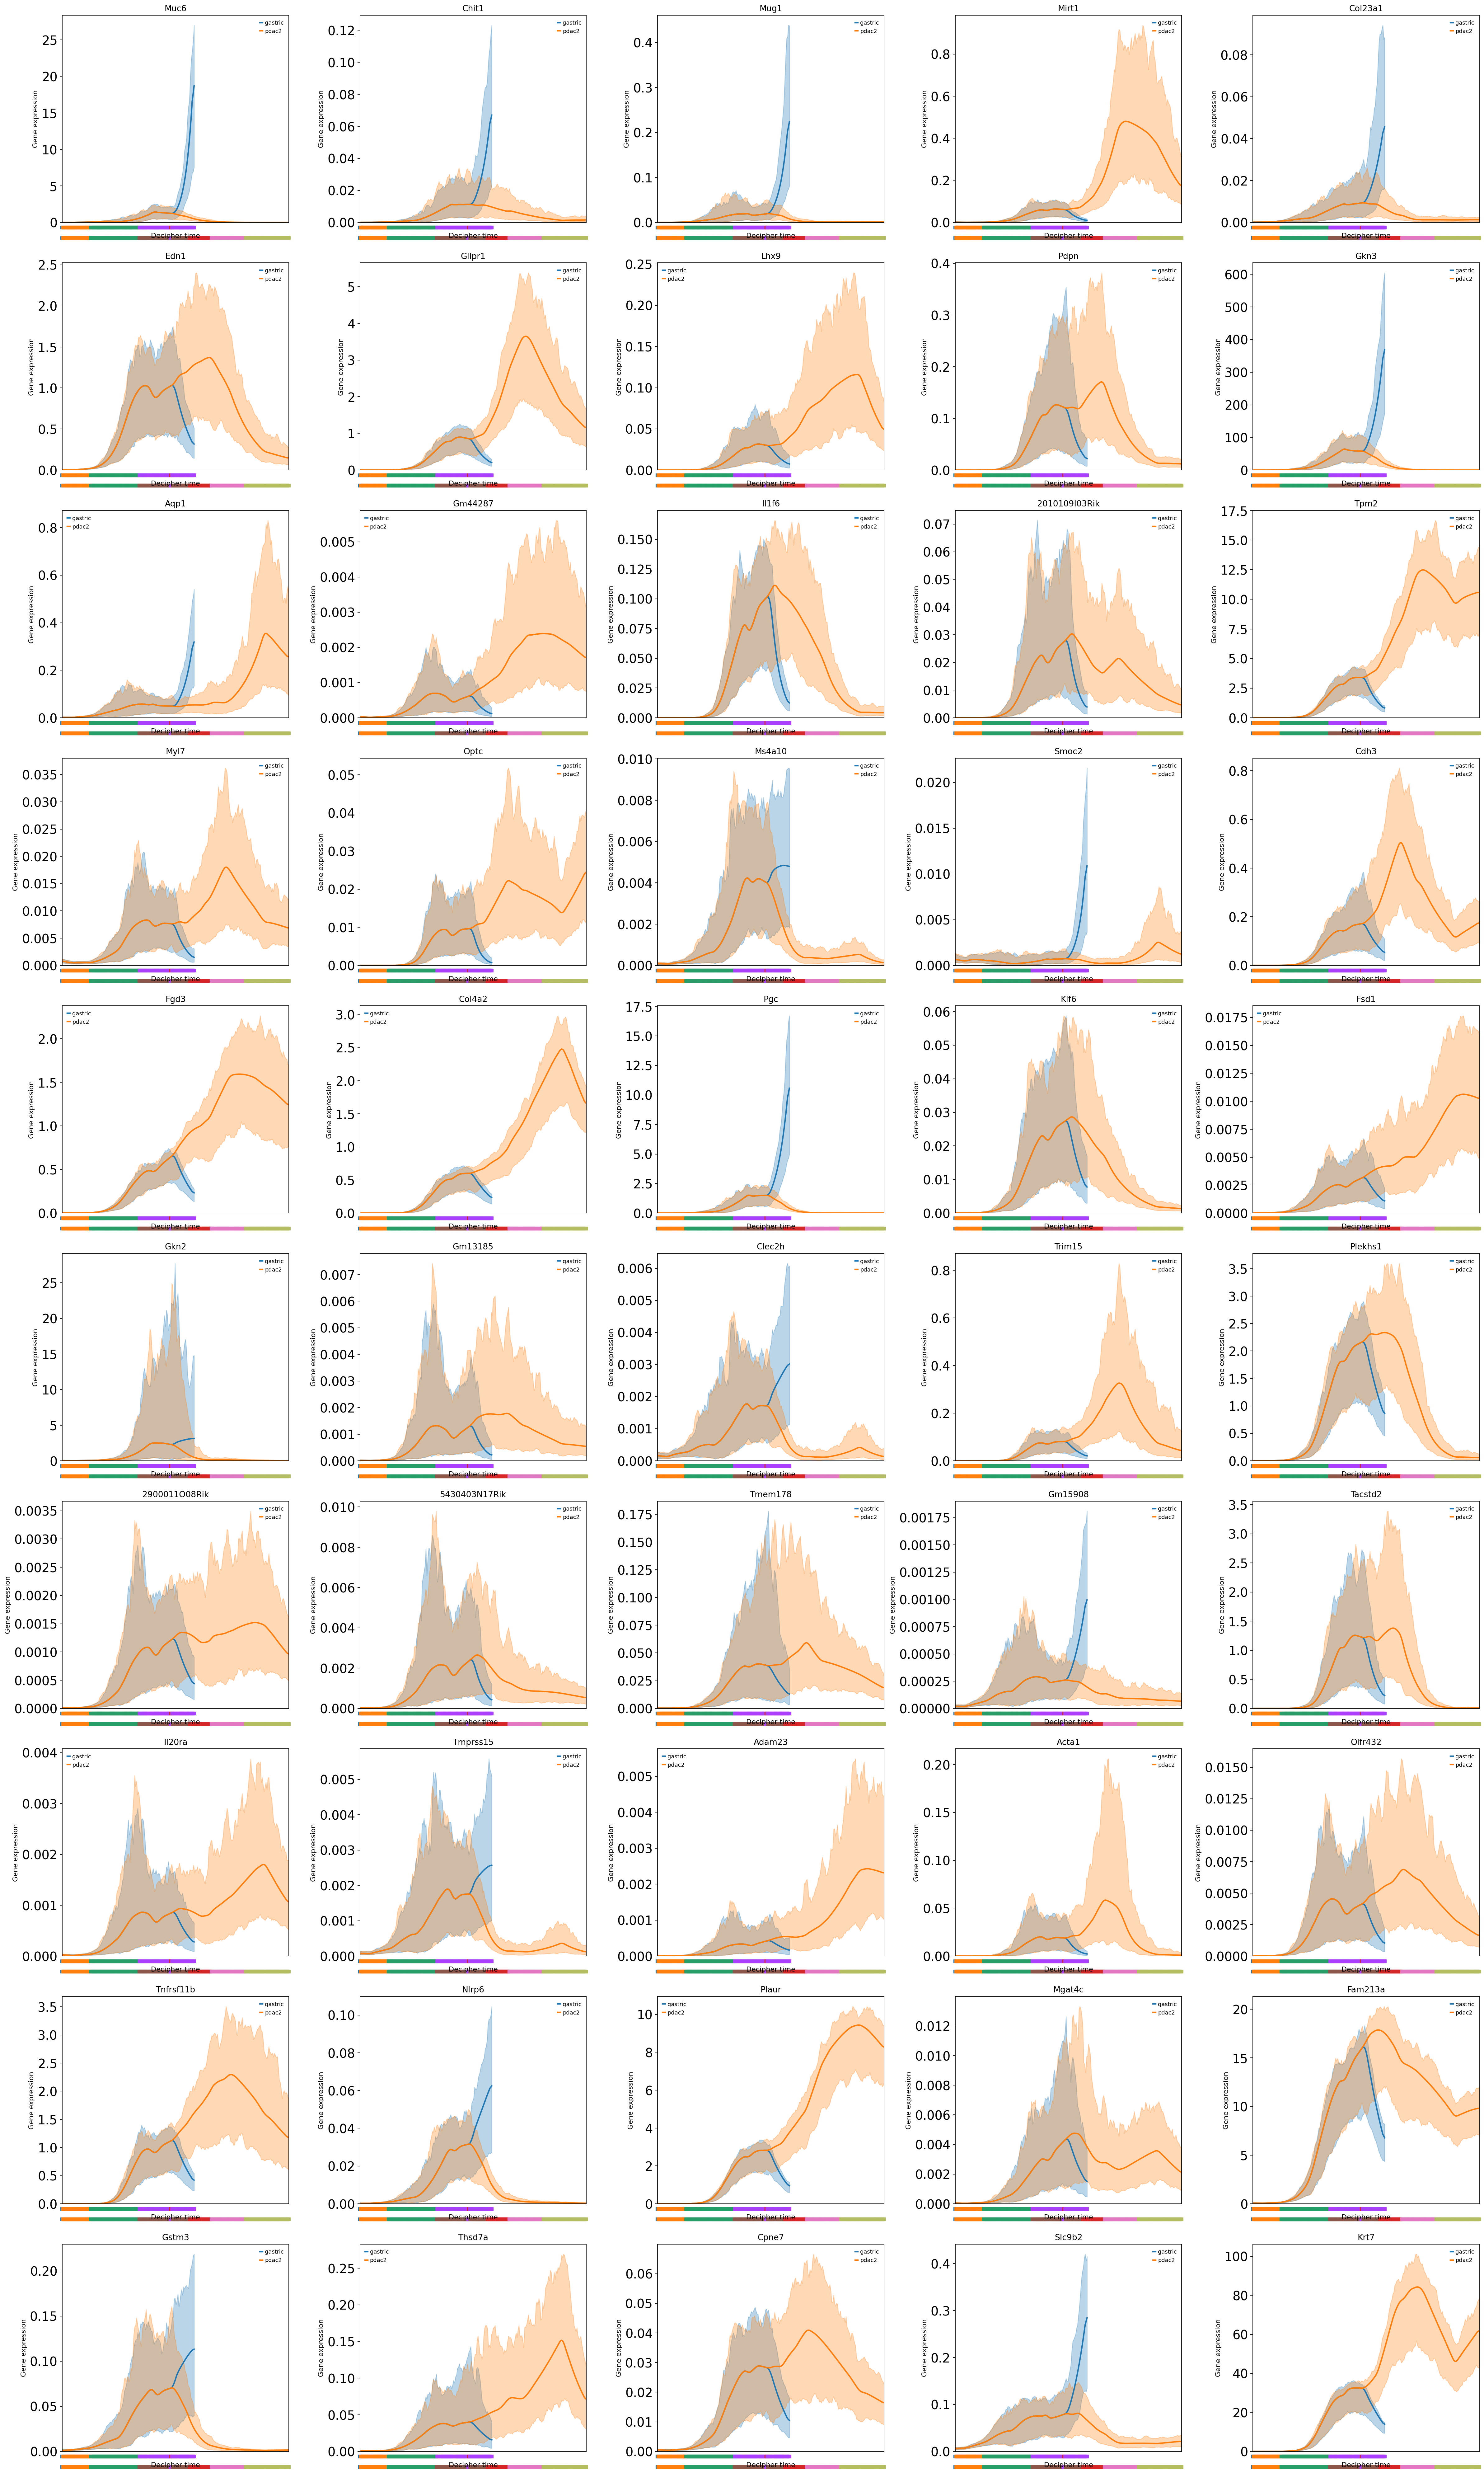

In [18]:
fig = gene_patterns(adata_hvg, top_disrupted_genes, 
                    cell_type_key="cell_type", time_axis="times", figsize=(30, 50),
                    nrows=10, ncols=5) # ['Tff1', 'Cldn4', 'Try4']


In [ ]:
training_losses = dc.tl.basis_decomposition(adata, seed=0);

In [ ]:
plt.rcParams["figure.figsize"] = [3,3]

... storing 'orig.ident' as categorical
... storing 'experiment' as categorical
... storing 'genotype' as categorical
... storing 'timepoint' as categorical
... storing 'mouse_id' as categorical
... storing 'replicate' as categorical
... storing 'doublet_finder' as categorical
... storing 'compartment' as categorical
... storing 'cell_type' as categorical


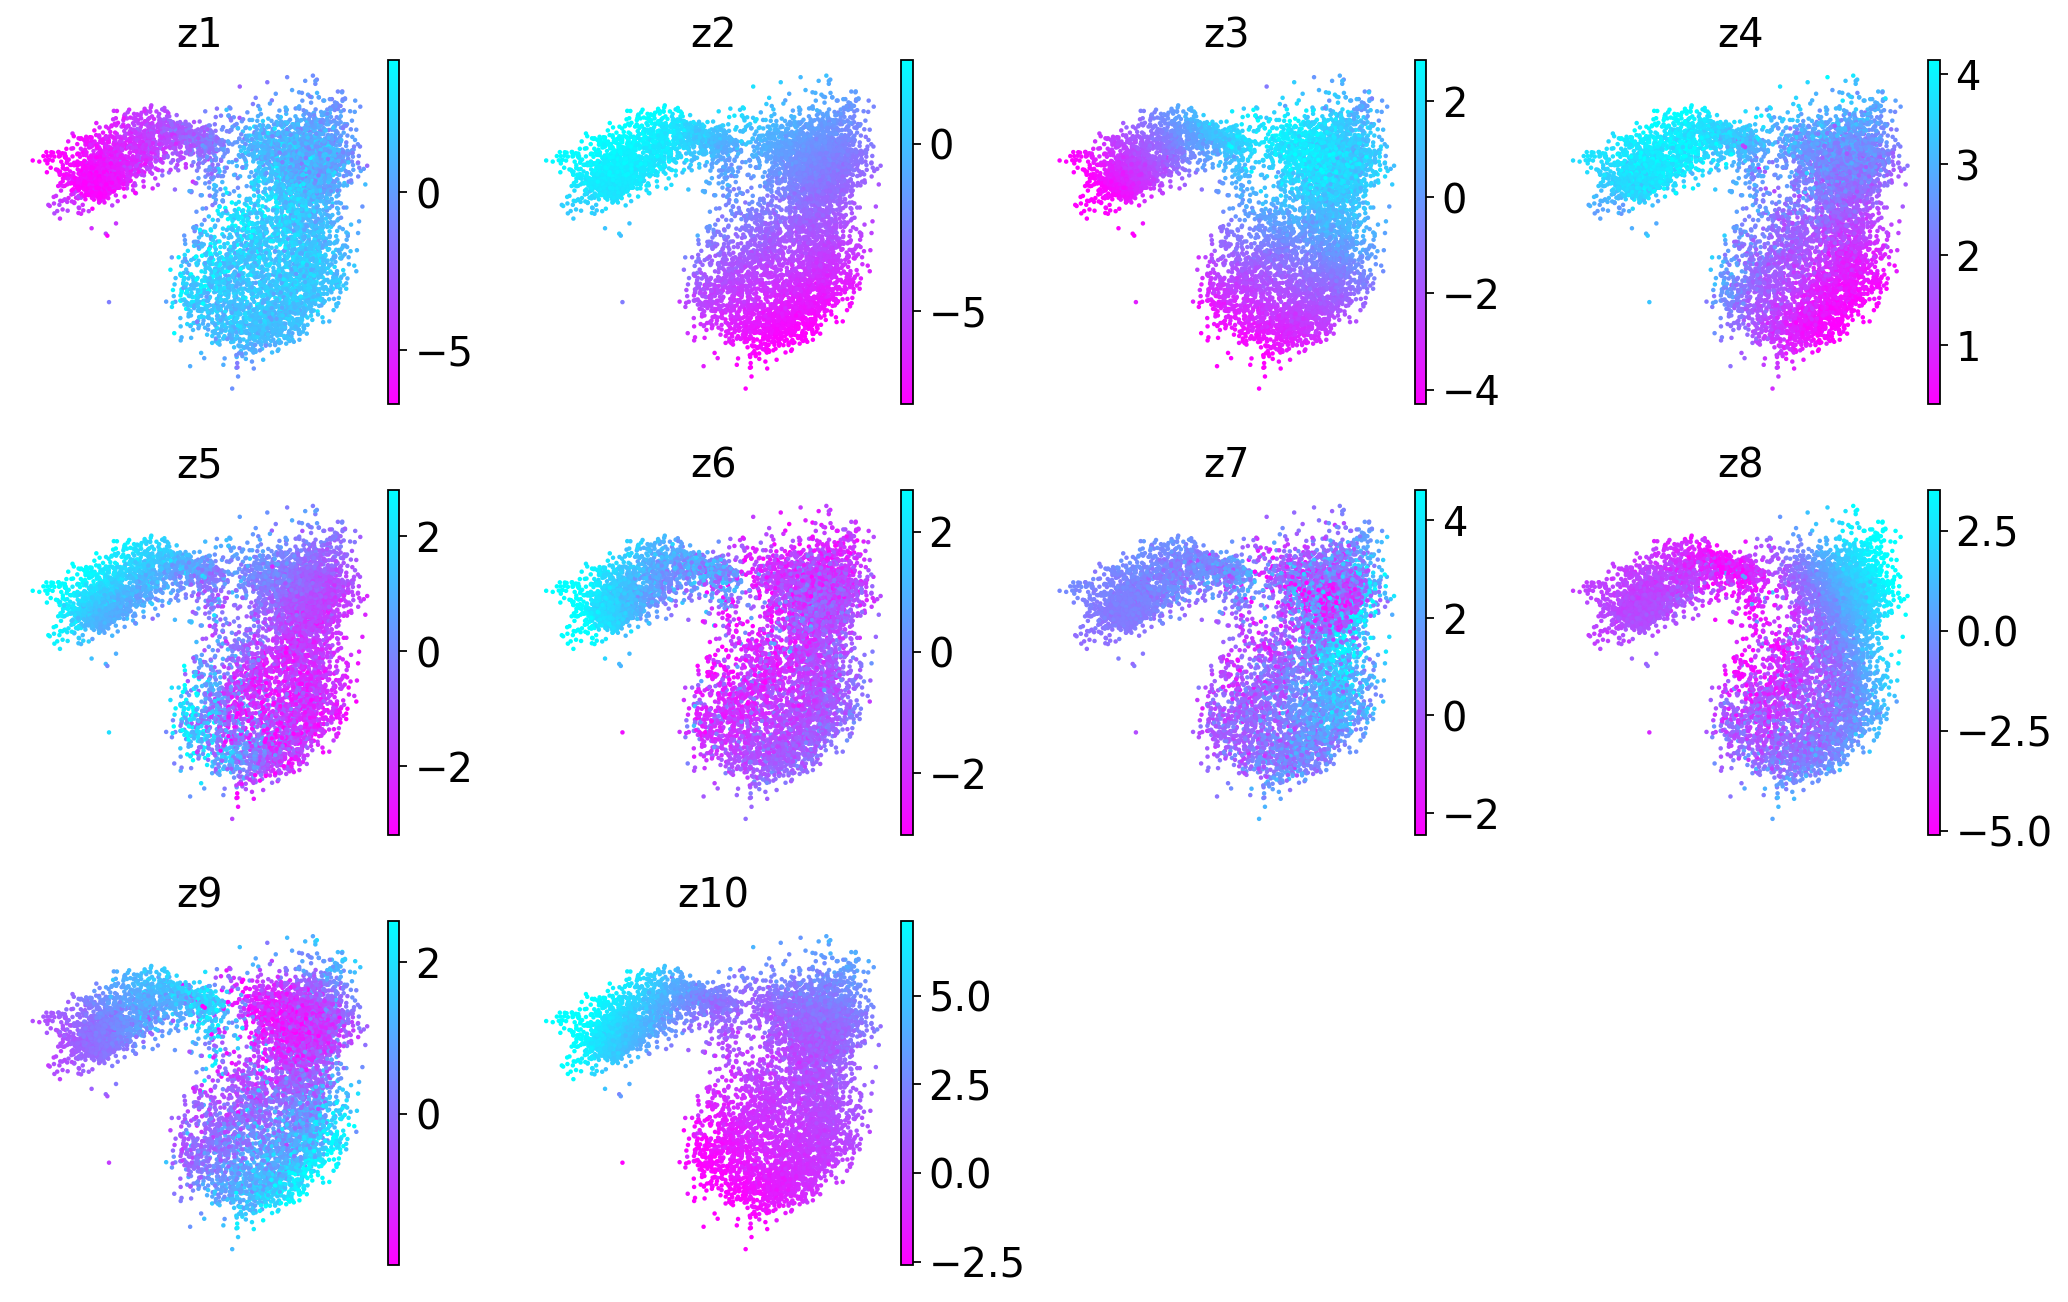

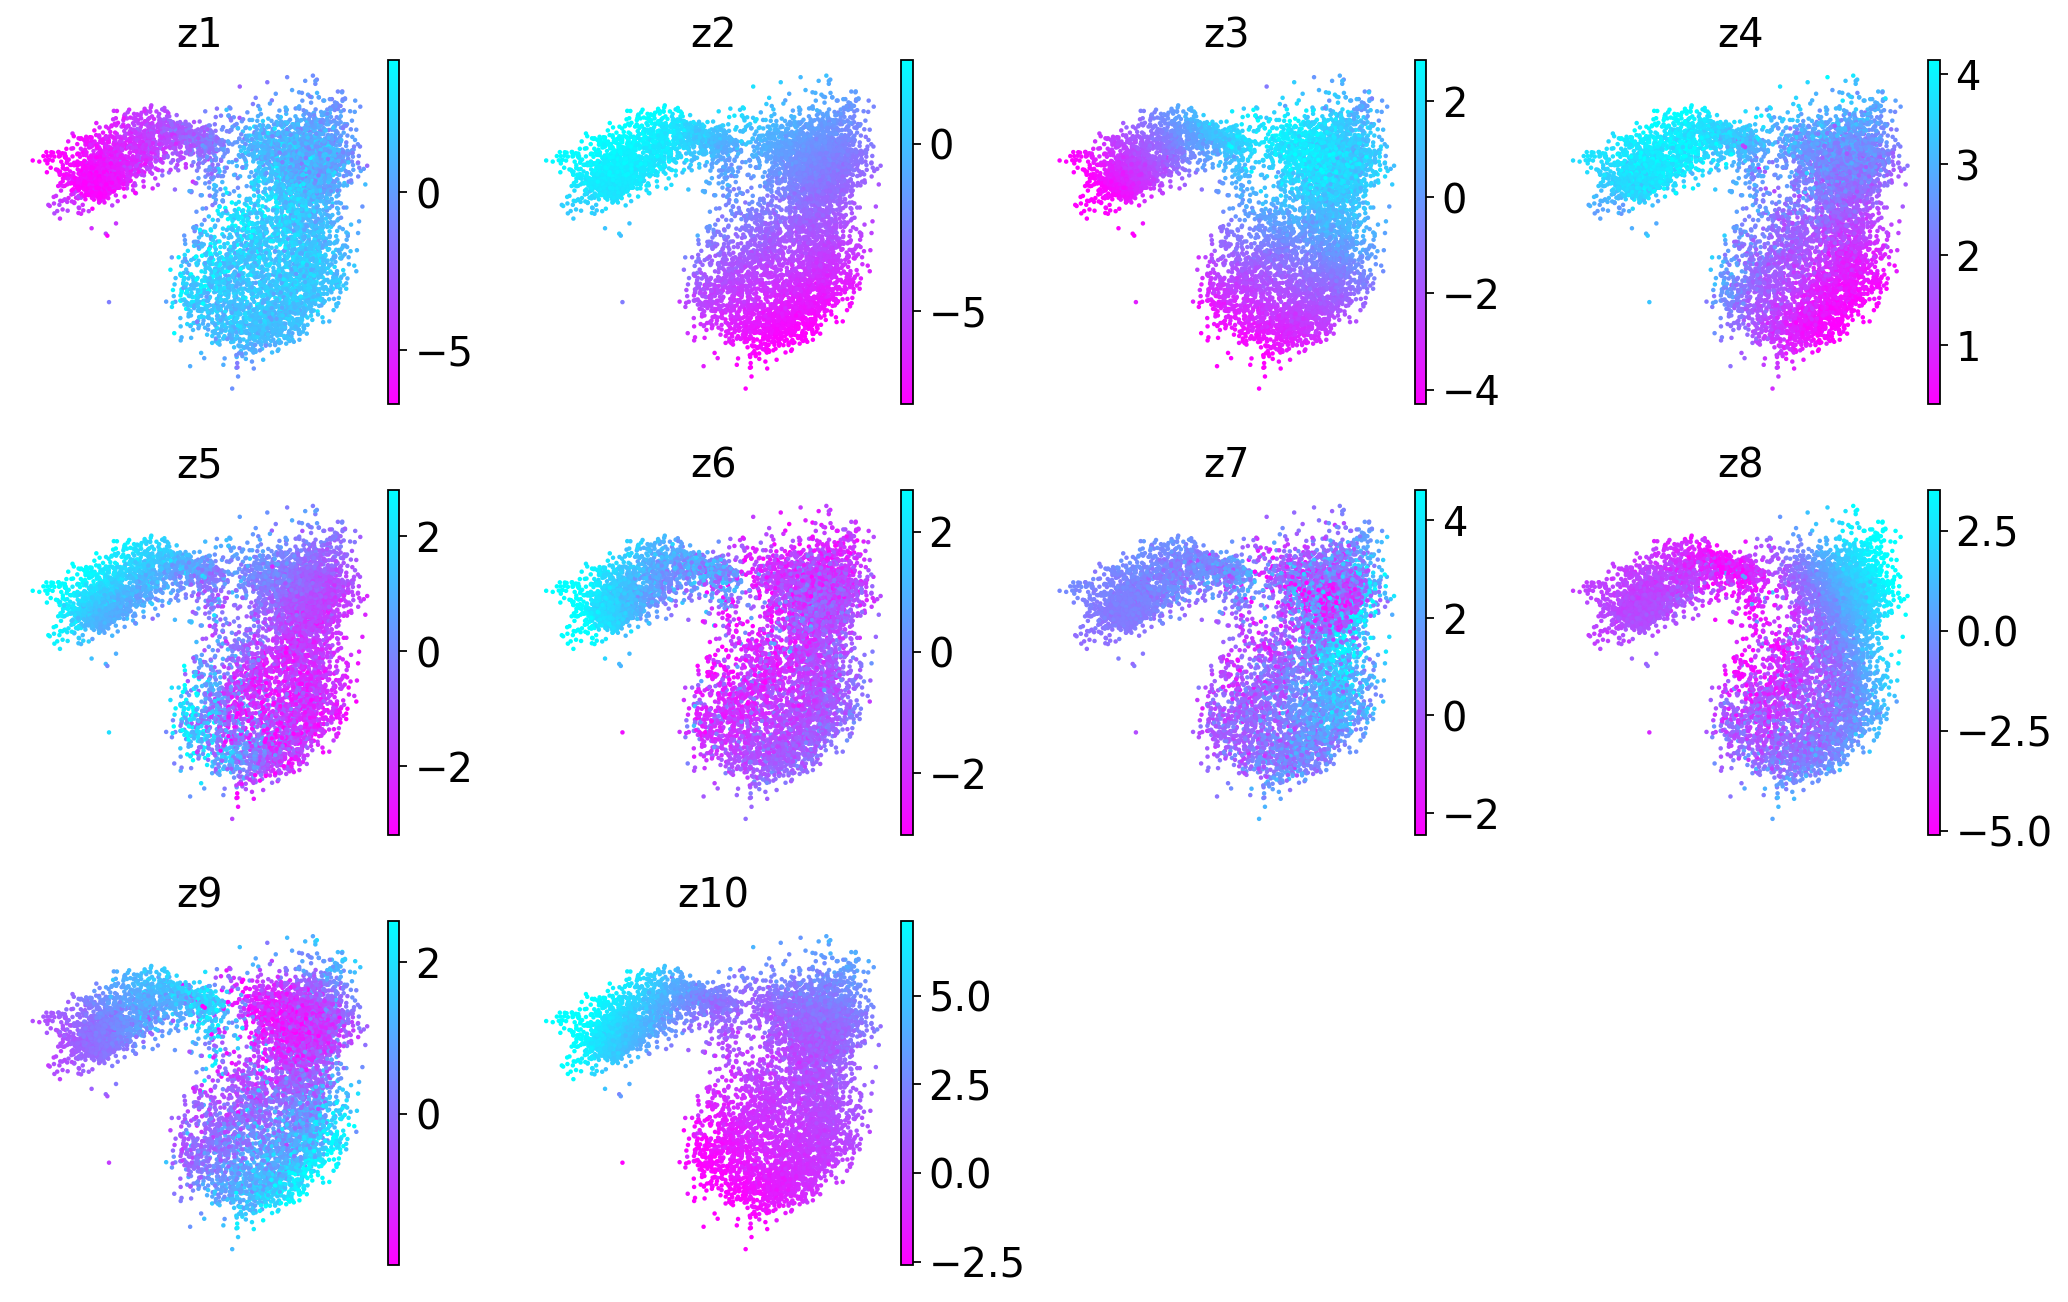

In [ ]:
fig = dc.pl.decipher_z(adata_hvg)

In [ ]:
adata_hvg.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb',
       'experiment', 'genotype', 'timepoint', 'mouse_id', 'replicate',
       'RNA_snn_res.1', 'seurat_clusters', 'RNA_snn_res.0.1',
       'pANN_0.25_0.02_26', 'doublet_finder', 'pANN_0.25_0.25_284',
       'pANN_0.25_0.02_6', 'pANN_0.25_0.02_15', 'pANN_0.25_0.07_53',
       'pANN_0.25_0.13_217', 'pANN_0.25_0.09_465', 'pANN_0.25_0.005_37',
       'pANN_0.25_0.06_64', 'compartment', 'RNA_snn_res.2', 'cluster1_1',
       'cluster2_1', 'cluster3_1', 'cluster4_1', 'cluster5_1', 'cluster6_1',
       'cell_type', 'decipher_split', 'decipher_z_clusters',
       'decipher_clusters', 'decipher_time', 'z1', 'z2', 'z3', 'z4', 'z5',
       'z6', 'z7', 'z8', 'z9', 'z10'],
      dtype='object')

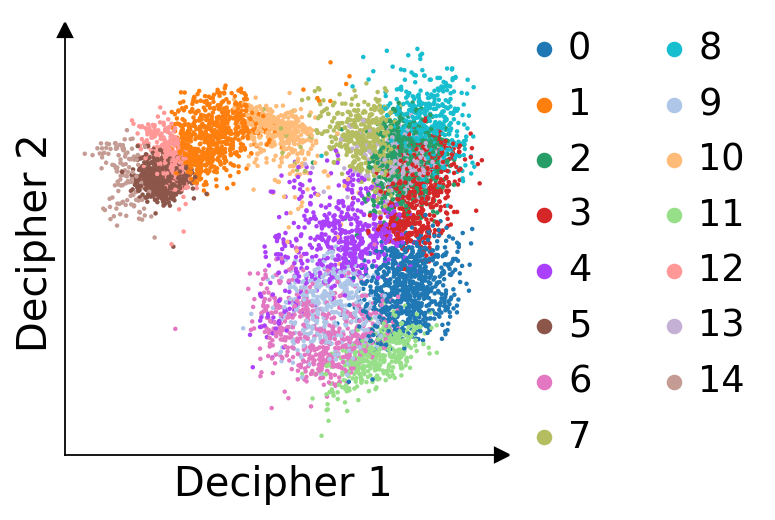

In [ ]:
# fig = dc.pl.decipher(adata_hvg, "decipher_clusters", cmap=sns.color_palette("YlOrBr_r", as_cmap=True, ))
# fig.axes[0].collections[-1].colorbar.set_label("Proportion F/WT", fontsize=14)

In [ ]:
sc.pl.embedding(adata_hvg,basis='decipher_v',color=['Tff1', 'Cldn4', 'Try4'], layer='decipher_imputed',vmax='p95',save="decipher_counts.pdf")

KeyError: 'counts'

<Figure size 1159.2x320 with 0 Axes>